# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [7]:
train = pd.read_parquet('./dataset/train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./dataset/test_agg_dwt.parquet.gzip') 

In [8]:
train.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,0.0,-7.682201,9.397065e+06,19.684417,0.307634,-1.194358,-0.042807,0.323890,4.054446,-0.092052,...,0.000000,4.115644,-4.319906,16.946974,0.0,116.871800,0.000000,1.0,2014-01-24 09:30:00,WELL-00001
1,0.0,-9.508595,9.397186e+06,50.369246,0.020586,-1.207112,-0.014607,0.323596,4.962313,-0.187287,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:35:00,WELL-00001
2,0.0,-9.508595,9.397360e+06,50.374443,-0.006722,-1.207770,0.008154,0.324156,4.961111,-0.315091,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:40:00,WELL-00001
3,0.0,-9.508595,9.397534e+06,50.379760,0.010809,-1.208115,-0.005925,0.328025,4.961434,-0.230442,...,1.873926,5.023578,-9.806816,99.180269,0.0,116.872561,0.001515,1.0,2014-01-24 09:45:00,WELL-00001
4,0.0,-9.508595,9.397708e+06,50.378701,-0.016459,-1.205876,0.011554,0.319672,4.961993,-0.333293,...,0.006362,5.023578,-9.806816,99.180269,0.0,116.887931,0.006060,1.0,2014-01-24 09:50:00,WELL-00001


In [9]:
test.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
376538,-6887865.0,10.998622,1.521178e+06,218536.270158,-0.079659,-0.675634,192.851944,3489.718994,3.815005,1.300725,...,0.019816,2.793830,6.569714,55.146750,-0.467070,118.475847,0.000119,0.0,2017-08-23 19:40:00,WELL-00001
376539,-6887865.0,10.998622,1.505095e+06,158973.414833,0.341871,0.097159,-14.542883,4290.028320,3.692357,0.479627,...,0.000000,4.571644,0.023032,21.115869,0.005965,118.476255,0.000115,0.0,2017-08-23 19:45:00,WELL-00001
376540,-6887865.0,10.998622,1.529431e+06,133163.617548,-0.183027,-0.107881,48.409313,3349.570068,3.515687,0.485914,...,-0.109348,3.698463,-9.908874,114.089318,-0.444411,118.476666,0.000121,0.0,2017-08-23 19:50:00,WELL-00001
376541,-6887865.0,10.998622,1.510778e+06,150536.803902,-0.152255,-0.691743,-148.623550,3882.586914,3.702601,-0.626575,...,0.051838,2.811349,-9.133902,100.976882,-0.916041,118.477074,0.000120,0.0,2017-08-23 19:55:00,WELL-00001
376542,-6887865.0,7.737584,1.482189e+06,173782.398244,0.077984,-0.634143,-187.743332,4627.182617,3.877089,-0.229050,...,0.026109,2.396014,3.989285,59.117225,-0.214526,118.477482,0.000125,0.0,2017-08-23 20:00:00,WELL-00001


In [10]:
test.tail()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
1090742,0.0,2.420422,1.515971e+06,19419.522020,0.005389,-0.996999,-24.636074,481.167725,3.725957,-0.432979,...,-0.815003,3.576356,2.155059,27.711037,-0.589910,109.730041,0.009750,1.0,2019-04-03 14:35:00,WELL-00018
1090743,0.0,-4.840377,1.513414e+06,21552.274830,0.326068,-0.613523,35.410950,406.365723,3.723744,0.994412,...,-0.365440,3.376124,-0.018400,23.270775,-0.459347,109.740899,0.011882,1.0,2019-04-03 14:40:00,WELL-00018
1090744,0.0,-6.508611,1.529739e+06,24276.819194,-0.559811,-1.003832,6.863686,411.907715,3.860695,-0.527096,...,-1.263903,3.276488,3.807797,18.896458,-0.191316,109.728768,0.008135,1.0,2019-04-03 14:45:00,WELL-00018
1090745,0.0,-4.932309,1.509833e+06,24172.229213,-0.350469,0.195717,-17.798183,461.665955,3.608607,-2.052634,...,-0.880939,3.480359,-0.729670,18.025547,0.368275,109.745786,0.016534,1.0,2019-04-03 14:50:00,WELL-00018
1090746,0.0,1.124709,1.491369e+06,15107.275344,0.348815,-0.444198,-6.247903,366.683838,3.502671,-0.298244,...,-0.601501,3.585752,3.410327,21.792006,-0.462479,109.754259,0.016178,1.0,2019-04-03 14:55:00,WELL-00018


In [11]:
test.shape

(7350, 59)

In [12]:
train.target.value_counts()

target
0.0    19594
1.0     9789
Name: count, dtype: int64

In [13]:
feature_model= [col for col in train.columns if col not in ['timestamp', 'well', 'target']]
feature_model

['P-PDG_mean',
 'P-JUS-CKGL_skew_L1',
 'P-MON-CKP_mean',
 'P-MON-CKP_std',
 'P-MON-CKP_skew_L0',
 'P-MON-CKP_kurtosis_L0',
 'P-MON-CKP_mean_L1',
 'P-MON-CKP_std_L1',
 'P-MON-CKP_entropy_L1',
 'P-MON-CKP_skew_L1',
 'P-MON-CKP_kurtosis_L1',
 'T-JUS-CKP_mean',
 'T-JUS-CKP_std',
 'T-TPT_skew_L1',
 'T-JUS-CKP_skew_L0',
 'T-JUS-CKP_mean_L1',
 'T-JUS-CKP_std_L1',
 'T-JUS-CKP_entropy_L1',
 'T-JUS-CKP_skew_L1',
 'T-JUS-CKP_kurtosis_L1',
 'P-JUS-CKGL_mean',
 'P-JUS-CKGL_std',
 'P-JUS-CKGL_skew_L0',
 'P-JUS-CKGL_kurtosis_L0',
 'P-JUS-CKGL_mean_L1',
 'P-JUS-CKGL_std_L1',
 'P-JUS-CKGL_entropy_L1',
 'T-JUS-CKP_kurtosis_L0',
 'T-TPT_entropy_L1',
 'T-TPT_kurtosis_L1',
 'T-TPT_mean_L1',
 'P-PDG_std',
 'P-PDG_mean_L0',
 'P-PDG_energy_L0',
 'P-PDG_skew_L0',
 'P-PDG_kurtosis_L0',
 'P-PDG_std_L1',
 'P-PDG_entropy_L1',
 'P-PDG_skew_L1',
 'P-PDG_kurtosis_L1',
 'P-TPT_mean',
 'P-TPT_std',
 'P-TPT_entropy_L0',
 'P-TPT_energy_L0',
 'P-JUS-CKGL_kurtosis_L1',
 'P-TPT_kurtosis_L0',
 'T-TPT_kurtosis_L0',
 'P-TPT_me

In [14]:
development = train.reset_index(drop=True)

development.shape

(29383, 59)

In [15]:
validation = test.reset_index(drop=True)
validation.shape

(7350, 59)

In [16]:
validation.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,-6887865.0,10.998622,1.521178e+06,218536.270158,-0.079659,-0.675634,192.851944,3489.718994,3.815005,1.300725,...,0.019816,2.793830,6.569714,55.146750,-0.467070,118.475847,0.000119,0.0,2017-08-23 19:40:00,WELL-00001
1,-6887865.0,10.998622,1.505095e+06,158973.414833,0.341871,0.097159,-14.542883,4290.028320,3.692357,0.479627,...,0.000000,4.571644,0.023032,21.115869,0.005965,118.476255,0.000115,0.0,2017-08-23 19:45:00,WELL-00001
2,-6887865.0,10.998622,1.529431e+06,133163.617548,-0.183027,-0.107881,48.409313,3349.570068,3.515687,0.485914,...,-0.109348,3.698463,-9.908874,114.089318,-0.444411,118.476666,0.000121,0.0,2017-08-23 19:50:00,WELL-00001
3,-6887865.0,10.998622,1.510778e+06,150536.803902,-0.152255,-0.691743,-148.623550,3882.586914,3.702601,-0.626575,...,0.051838,2.811349,-9.133902,100.976882,-0.916041,118.477074,0.000120,0.0,2017-08-23 19:55:00,WELL-00001
4,-6887865.0,7.737584,1.482189e+06,173782.398244,0.077984,-0.634143,-187.743332,4627.182617,3.877089,-0.229050,...,0.026109,2.396014,3.989285,59.117225,-0.214526,118.477482,0.000125,0.0,2017-08-23 20:00:00,WELL-00001


In [17]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [18]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(19594, 59)

In [19]:
development.head()

,P-PDG_mean,P-JUS-CKGL_skew_L1,P-MON-CKP_mean,P-MON-CKP_std,P-MON-CKP_skew_L0,P-MON-CKP_kurtosis_L0,P-MON-CKP_mean_L1,P-MON-CKP_std_L1,P-MON-CKP_entropy_L1,P-MON-CKP_skew_L1,...,T-TPT_skew_L0,P-TPT_entropy_L1,P-TPT_skew_L1,P-TPT_kurtosis_L1,P-TPT_skew_L0,T-TPT_mean,T-TPT_std,target,timestamp,well
0,0.0,-7.682201,9.397065e+06,19.684417,0.307634,-1.194358,-0.042807,0.323890,4.054446,-0.092052,...,0.000000,4.115644,-4.319906,16.946974,0.0,116.871800,0.000000,1.0,2014-01-24 09:30:00,WELL-00001
1,0.0,-9.508595,9.397186e+06,50.369246,0.020586,-1.207112,-0.014607,0.323596,4.962313,-0.187287,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:35:00,WELL-00001
2,0.0,-9.508595,9.397360e+06,50.374443,-0.006722,-1.207770,0.008154,0.324156,4.961111,-0.315091,...,0.000000,5.023578,-9.806816,99.180269,0.0,116.871800,0.000000,1.0,2014-01-24 09:40:00,WELL-00001
3,0.0,-9.508595,9.397534e+06,50.379760,0.010809,-1.208115,-0.005925,0.328025,4.961434,-0.230442,...,1.873926,5.023578,-9.806816,99.180269,0.0,116.872561,0.001515,1.0,2014-01-24 09:45:00,WELL-00001
4,0.0,-9.508595,9.397708e+06,50.378701,-0.016459,-1.205876,0.011554,0.319672,4.961993,-0.333293,...,0.006362,5.023578,-9.806816,99.180269,0.0,116.887931,0.006060,1.0,2014-01-24 09:50:00,WELL-00001


In [20]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [21]:
y_dev.sum()

9789.0

In [22]:
len(y_dev)

29383

In [23]:
X_no_anomalies = train_no_anomalies[feature_model].values

In [24]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # Histórico de métricas
        # self.metrics_history = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        # }
        self.metrics_history = {
            'roc_auc': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        # self.entropy_history = []  # Histórico de entropia
        # self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    # def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
    #     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    #     try:
    #         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    #     except:
    #           f1_scores = 0    
    #     best_idx = np.argmax(f1_scores)
    #     return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        # split_scores = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        # }
        split_scores = {
            'roc_auc': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = -pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            # y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            # y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            # precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            # recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            # f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)#, max_fpr=0.1)
            # try:
            #     roc_auc = roc_auc_score(y_test_split, y_pred)
            # except:
                # roc_auc=0    
            # pr_auc = average_precision_score(y_test_split, y_scores)      

            # Calcular especificidade
            # tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            # specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # split_scores['f1_score'].append(f1)
            # split_scores['precision'].append(precision)
            # split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            # split_scores['pr_auc'].append(pr_auc)
            # split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            # "mean_test_f1_score": np.mean(split_scores['f1_score']),
            # "std_test_f1_score": np.std(split_scores['f1_score']),
            # "mean_test_specificity": np.mean(split_scores['specificity']),
            # "std_test_specificity": np.std(split_scores['specificity']),
            # "mean_test_precision": np.mean(split_scores['precision']),
            # "std_test_precision": np.std(split_scores['precision']),
            # "mean_test_recall": np.mean(split_scores['recall']),
            # "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            # "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            # "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))

        # reward = 100*(np.mean(split_scores['pr_auc']) - np.std(split_scores['pr_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1  # Gini

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)
    

# from sklearn.ensemble import IsolationForest

# def isolation_forest_factory(**params):
#     return IsolationForest(
#         n_estimators=int(params['n_estimators']),
#         contamination=params['contamination'],
#         max_samples=params['max_samples'],
#         max_features=int(params['max_features']),
#         # bootstrap=bool(params['bootstrap']),
#         random_state=42
#     )

# param_ranges_if = {
#     'n_estimators': (50, 256),
#     'contamination': (0.001, 0.01),
#     'max_samples': (0.7, 1.0),
#     'max_features': (0.7, 1.0)
#     # 'bootstrap': (0, 1)  # 0 = False, 1 = True
# }


# # === Configuração do TimeSeriesSplit ===
# tscv = TimeSeriesSplit(n_splits=3)

# # === Configuração do Ambiente e SAC ===
# # env = IsolationForestEnv(X, y, tscv, feature_model)
# env = AnomalyDetectionEnv(X, y, tscv, feature_model, isolation_forest_factory, param_ranges_if)

# # Modelo SAC
# model_iforest_sac = SAC(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=0.001,  # Reduzir a taxa de aprendizado
#     buffer_size=10000,  # Aumentar o tamanho do buffer
#     batch_size=256,       # Aumentar o tamanho do batch
#     gamma=0.99,          # Fator de desconto
#     tau=0.005,           # Taxa de atualização do target network
#     ent_coef='auto',     # Coeficiente de entropia automático
#     target_entropy='auto'
# )

# # Treinamento do agente
# model_iforest_sac.learn(total_timesteps=200)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [25]:
from sklearn.ensemble import IsolationForest

def isolation_forest_factory(**params):
    return IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=int(params['max_features']),
        # bootstrap=bool(params['bootstrap']),
        random_state=42
    )

param_ranges_if = {
    'n_estimators': (5, 256),
    'contamination': (0.0001, 0.005),
    'max_samples': (0.3, 1.0),
    'max_features': (0.3, 1.0)
    # 'bootstrap': (0, 1)  # 0 = False, 1 = True
}

In [26]:
# === Visualização das Métricas ===
def plot_metrics(metrics_history):
    plt.figure(figsize=(12, 8))
    for metric, values in metrics_history.items():
        plt.plot(values, label=metric)
    plt.xlabel('Episódios')
    plt.ylabel('Valor da Métrica')
    plt.title('Evolução das Métricas Durante o Treinamento')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import torch

class SACMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(SACMetricsCallback, self).__init__(verbose)
        self.rewards_history = []
        self.q_values_mean_history = []
        self.q_values_std_history = []
        self.q_values_q1_history = []
        self.q_values_q2_history = []

    def _on_step(self) -> bool:
        # Armazenar recompensas
        if "rewards" in self.locals:
            self.rewards_history.append(self.locals["rewards"][0])

        # Obter o estado atual do ambiente
        if self.training_env is not None:
            obs = self.training_env.get_attr('state')[0]

            if isinstance(obs, np.ndarray):
                obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.model.device).unsqueeze(0)
                with torch.no_grad():
                    actions = self.model.policy.actor(obs_tensor)
                    if isinstance(actions, tuple):
                        actions = actions[0]

                    # Chamando o critic corretamente (retorna q1 e q2)
                    q1, q2 = self.model.policy.critic(obs_tensor, actions)

                    # Salvar valores separadamente
                    q1_value = q1.mean().item()
                    q2_value = q2.mean().item()
                    self.q_values_q1_history.append(q1_value)
                    self.q_values_q2_history.append(q2_value)

                    # Salvar média e desvio padrão
                    q_values = torch.cat([q1, q2], dim=1)
                    self.q_values_mean_history.append(q_values.mean().item())
                    self.q_values_std_history.append(q_values.std().item())

        return True


In [28]:
import time
# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, isolation_forest_factory, param_ranges_if)

# Modelo SAC
model_iforest_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)


start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_iforest_sac.learn(total_timesteps=1000, callback=callback)

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 64.7     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 15       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 67.2     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 23       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 66.8     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [29]:
results_df_iforest = env.get_results_table()
results_df_iforest.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_estimators': 217.86851501464844, 'contamin...","{'roc_auc': [0.5597972411127242, 0.834375, 0.9...",0.795237,0.178417,1.276407,0.400858,0.233883,0.072304
1,"{'n_estimators': 201.32394409179688, 'contamin...","{'roc_auc': [0.5730897619721834, 0.82299599644...",0.796460,0.172571,1.139867,0.472761,0.169934,0.077533
2,"{'n_estimators': 135.99502563476562, 'contamin...","{'roc_auc': [0.6238917280826478, 0.82346975088...",0.812383,0.149582,0.815065,0.256505,0.093773,0.021112
3,"{'n_estimators': 177.58090209960938, 'contamin...","{'roc_auc': [0.6523861713035171, 0.82587588967...",0.823297,0.138508,1.314002,0.408572,0.129167,0.007487
4,"{'n_estimators': 33.791587829589844, 'contamin...","{'roc_auc': [0.7119711595846636, 0.74117304270...",0.810448,0.119216,0.193203,0.051781,0.025197,0.001399


In [30]:
results_df_iforest.to_csv('./metrics_anomaly_detection/results_df_iforest_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

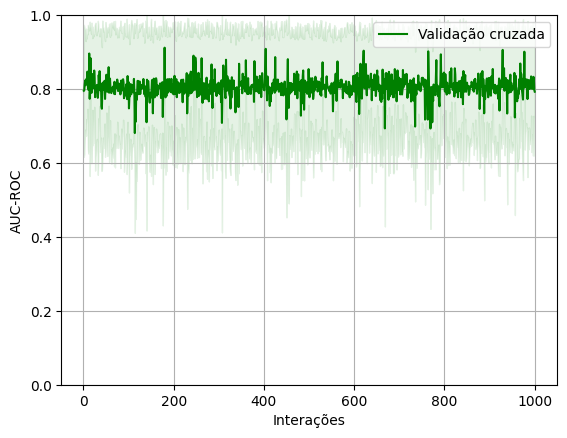

In [31]:
results_df_iforest2 = pd.read_csv('./metrics_anomaly_detection/results_df_iforest_dwt.csv')

results_df_iforest2  = results_df_iforest2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [32]:
# IsolationForest(contamination=0.0002, max_features=0.94, max_samples=0.37,
#                 n_estimators=76, random_state=42)

In [33]:
results_df_iforest['roc_auc_adjusted'] = results_df_iforest['mean_test_roc_auc'] - results_df_iforest['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = results_df_iforest.loc[999]
best_params = results_df_iforest.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'n_estimators': 22.426830291748047, 'contamination': 0.004999999888241291, 'max_samples': 0.9235497117042542, 'max_features': 0.6287025213241577}

Métricas: params               {'n_estimators': 22.426830291748047, 'contamin...
fold_scores          {'roc_auc': [0.8976059878271752, 0.85492838078...
mean_test_roc_auc                                             0.911936
std_test_roc_auc                                              0.053368
mean_fit_time                                                 0.177288
std_fit_time                                                  0.026976
mean_score_time                                               0.019814
std_score_time                                                0.003328
roc_auc_adjusted                                              0.858568
Name: 179, dtype: object


In [34]:
# best_params_idx 

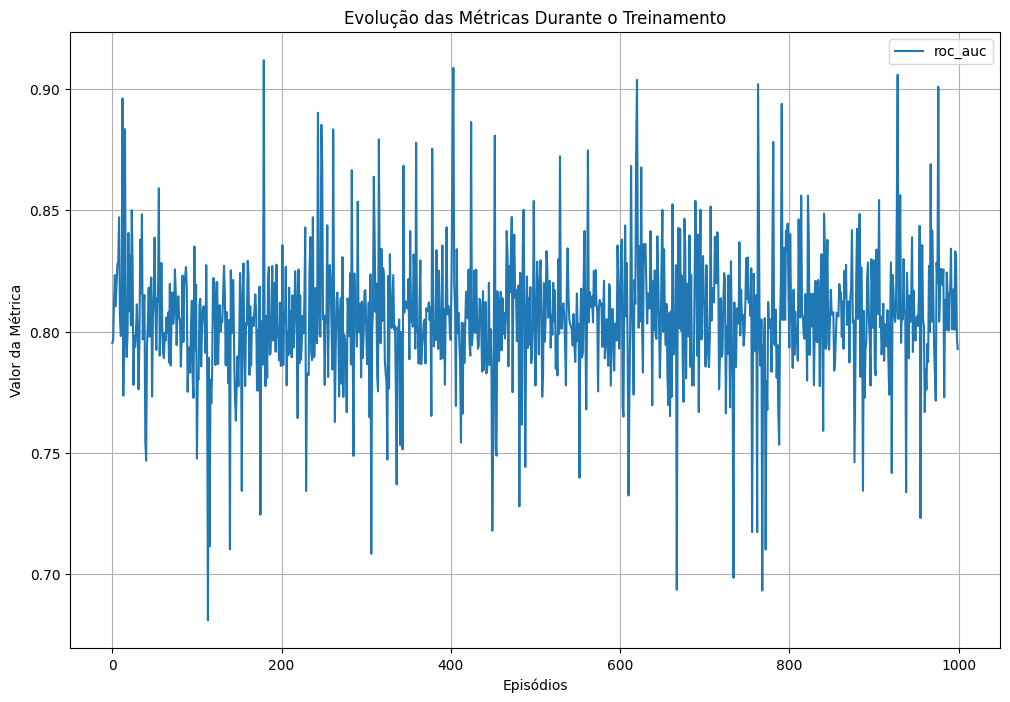

In [35]:

plot_metrics(env.metrics_history)


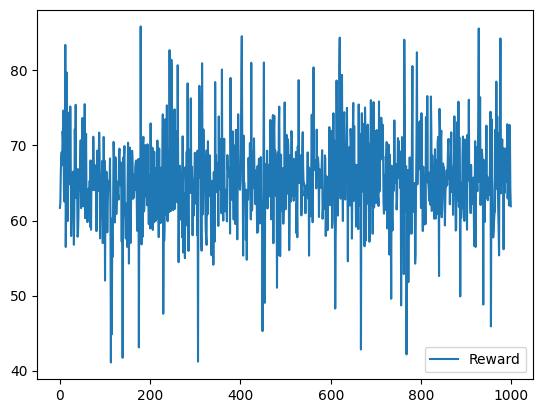

In [36]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

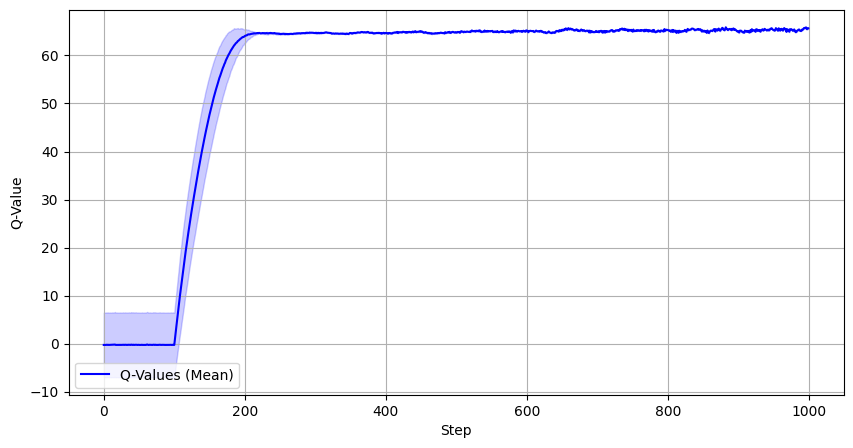

In [37]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()

q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_anomaly_detection/q_values_mean_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_anomaly_detection/q_values_q1_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_anomaly_detection/q_values_q2_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_anomaly_detection/q_values_std_history_iforest_dwt.csv', index=False)

In [39]:
best_params['params']

{'n_estimators': 22.426830291748047,
 'contamination': 0.004999999888241291,
 'max_samples': 0.9235497117042542,
 'max_features': 0.6287025213241577}

In [40]:
n_estimators_best = int(best_params['params'].get('n_estimators'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
max_samples_best = round(float(best_params['params'].get('max_samples')), 2)
max_features_best = round(float(best_params['params'].get('max_features')), 2)
bootstrap_best = bool(best_params['params'].get('bootstrap'))

print(f"Melhores hiperparâmetros encontrados: n_estimators={n_estimators_best}, contamination={contamination_best}, "
      f"max_samples={max_samples_best}, max_features={max_features_best}, bootstrap={bootstrap_best}")

Melhores hiperparâmetros encontrados: n_estimators=22, contamination=0.005, max_samples=0.92, max_features=0.63, bootstrap=False


In [41]:
# IsolationForest(contamination=0.0002, max_features=0.94, max_samples=0.37,
#                 n_estimators=76, random_state=42)

# n_estimators_best= 76
# contamination_best = 0.0002
# max_samples_best = 0.37
# max_features_best = 0.94

In [42]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    bootstrap=bootstrap_best,
    random_state=42
)

# estimator = IsolationForest(random_state=42, **best_params['params'])
# estimator = IsolationForest(random_state=42, **best_params2)

best_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

best_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 IsolationForest(contamination=0.005, max_features=0.63,
                                 max_samples=0.92, n_estimators=22,
                                 random_state=42))])

In [43]:
std = StandardScaler()
std.fit(X_no_anomalies)

StandardScaler()

In [44]:
# def find_optimal_threshold(y_true, y_scores, metric='f1'):
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
#     try:
#         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
#     except:
#             f1_scores = 0    
#     best_idx = np.argmax(f1_scores)
#     return thresholds[best_idx], f1_scores[best_idx]

# def find_optimal_threshold(y_true, y_scores):  
#     # Calcula a curva ROC  
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)  
    
#     # Calcula a AUC  
#     roc_auc = auc(fpr, tpr)  

#     # Calcula o ponto ótimo com base na distância euclidiana  
#     optimal_idx = np.argmax(tpr - fpr)  # ou você pode usar outra abordagem  

#     return thresholds[optimal_idx], roc_auc


In [162]:
scores_dev = -best_model_iforest.decision_function(X_dev)
final_auc = roc_auc_score(y_dev, scores_dev, max_fpr=1)
print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9498


Melhor Threshold: -0.0943


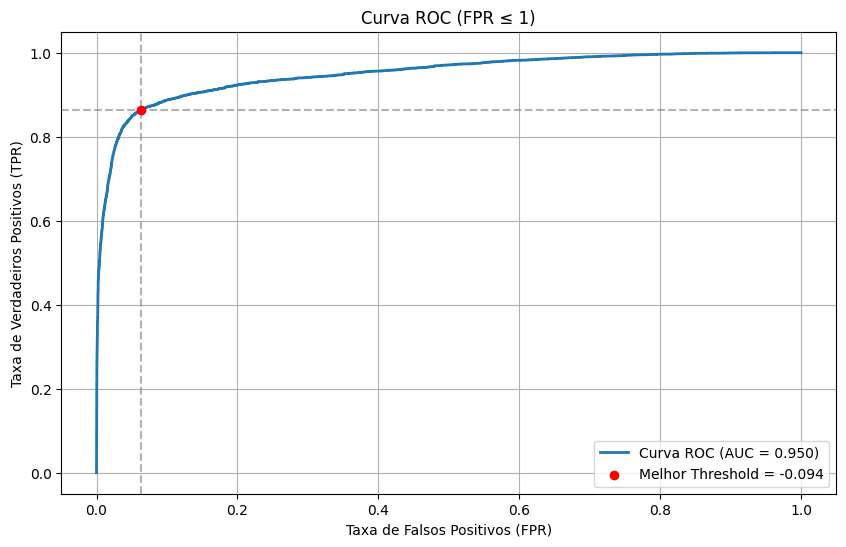

In [163]:
# Primeiro, calcula os valores da ROC e o melhor threshold
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(
    y_dev, scores_dev, max_fpr=1
)

print(f"Melhor Threshold: {best_threshold:.4f}")

# Depois, plota a curva ROC usando os valores calculados
plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=1)

In [164]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

# y_pred = best_model_iforest.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

Melhor Threshold (FPR ≤ 1): -0.0943, AUC: 0.9498
Melhore threshold:  -0.09429365327780764


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93227   0.93712   0.93469     19594
         1.0    0.87282   0.86372   0.86825      9789

    accuracy                        0.91267     29383
   macro avg    0.90254   0.90042   0.90147     29383
weighted avg    0.91246   0.91267   0.91256     29383

Specificity: 0.9371236092681433
Gini:  0.8995890350809554
ROC AUC::  0.9497945175404777


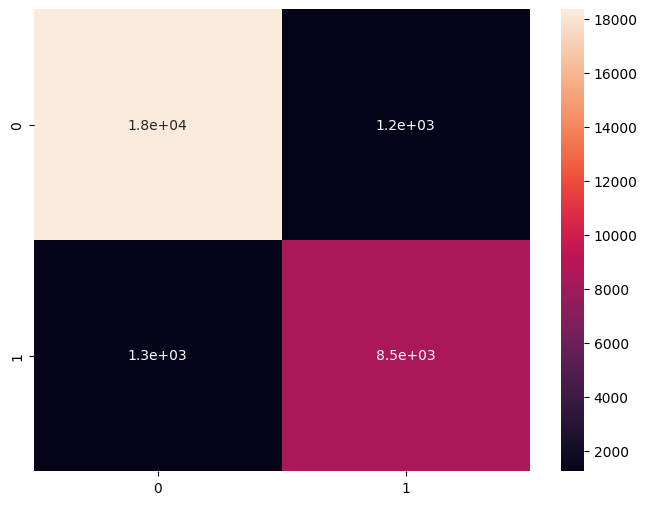

In [165]:
metrics(y_dev, y_pred, scores_dev)

In [166]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [167]:
best_model_iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 IsolationForest(contamination=0.005, max_features=0.63,
                                 max_samples=0.92, n_estimators=22,
                                 random_state=42))])

In [168]:
# assert np.isfinite(validation[feature_model].values).all(), "Ainda existem valores inválidos em X_valid!"

In [ ]:
scores_valid = -best_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = best_model_iforest.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

In [170]:
# scores_valid = -best_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid, max_fpr=1)
print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.8875


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.97436   0.67817   0.79972      5099
         1.0    0.56827   0.95957   0.71381      2251

    accuracy                        0.76435      7350
   macro avg    0.77132   0.81887   0.75677      7350
weighted avg    0.84999   0.76435   0.77341      7350

Specificity: 0.6781721906256128
Gini:  0.7750402536224341
ROC AUC::  0.8875201268112171


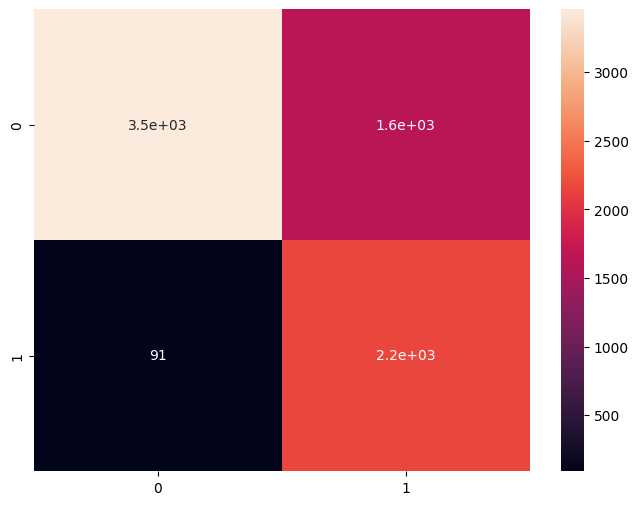

In [171]:
metrics(y_valid, y_pred, scores_valid)

In [172]:
# scores = -best_model_iforest.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores)

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

In [173]:
validation['scores_forest']=-best_model_iforest.decision_function(X_valid)

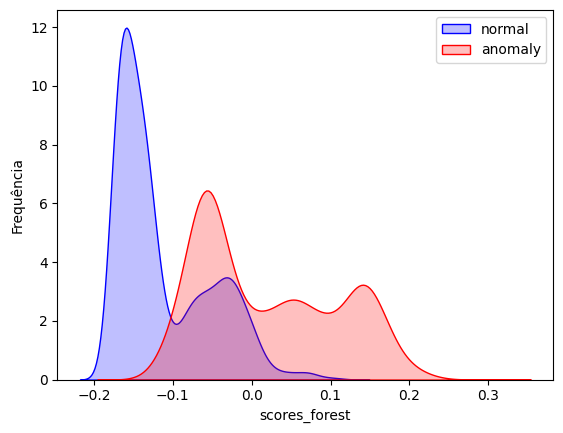

In [174]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [58]:
with open('./models/pipeline_iForest_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_iforest, file)

In [59]:
# with open('./models/pipeline_iForest_RL.pkl', 'rb') as f:
#     iforest_old = pickle.load(f) 

# iforest_old

## Local Outlier Factor

In [60]:
from sklearn.neighbors import LocalOutlierFactor

In [61]:
def lof_factory(**params):
    return LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )

param_ranges_lof = {
    'n_neighbors': (3, 25),
    'contamination': (0.0001, 0.005)
}

In [62]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env_lof = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, lof_factory, param_ranges_lof)

# Modelo SAC
model_lof_sac = SAC(
    "MlpPolicy",
    env_lof,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro
# Treinamento do agente
callback = SACMetricsCallback()
model_lof_sac.learn(total_timesteps=1000, callback=callback)
total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 73.4     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 15       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 72.3     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 31       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 72.2     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [63]:

results_df_lof = env_lof.get_results_table()
results_df_lof.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_neighbors': 6.558262825012207, 'contaminat...","{'roc_auc': [0.7850632937943766, 0.76501779359...",0.849735,0.105950,1.091782,0.745927,0.422202,0.238006
1,"{'n_neighbors': 14.246927261352539, 'contamina...","{'roc_auc': [0.7945338902847633, 0.72671530249...",0.840202,0.115895,0.736073,0.650911,0.424704,0.233666
2,"{'n_neighbors': 5.30190896987915, 'contaminati...","{'roc_auc': [0.7802314205108152, 0.78154759786...",0.853734,0.103019,0.746135,0.645475,0.445994,0.278002
3,"{'n_neighbors': 16.556591033935547, 'contamina...","{'roc_auc': [0.7861792442700477, 0.72183807829...",0.835772,0.118577,0.757733,0.586132,0.469846,0.248827
4,"{'n_neighbors': 21.49825096130371, 'contaminat...","{'roc_auc': [0.7451632573867732, 0.71376067615...",0.819393,0.127827,0.969910,0.884322,0.488028,0.216640


In [64]:
results_df_lof.to_csv('./metrics_anomaly_detection/results_df_lof_dwt.csv', index=False)

In [65]:

results_df_lof['roc_auc_adjusted'] = results_df_lof['mean_test_roc_auc'] - results_df_lof['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_lof.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 



Melhores parâmetros encontrados (máxima média ajustada): {'n_neighbors': 3.2586333751678467, 'contamination': 0.004839002154767513}

Métricas: params               {'n_neighbors': 3.2586333751678467, 'contamina...
fold_scores          {'roc_auc': [0.7854710689402191, 0.81372108540...
mean_test_roc_auc                                             0.866174
std_test_roc_auc                                               0.09486
mean_fit_time                                                 0.790175
std_fit_time                                                  0.625355
mean_score_time                                               0.421296
std_score_time                                                0.164529
roc_auc_adjusted                                              0.771315
Name: 6, dtype: object


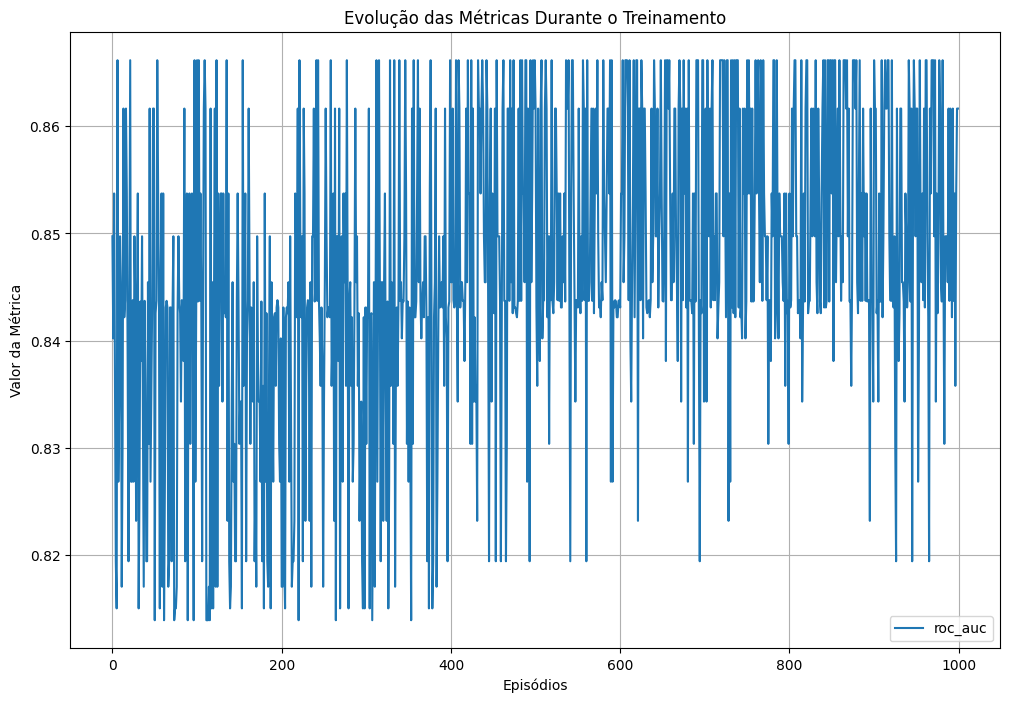

In [66]:
plot_metrics(env_lof.metrics_history)

In [67]:
# def plot_metrics_reward(metrics_history):
#     plt.figure(figsize=(12, 8))
#     plt.plot(metrics_history, label="Reward")
#     plt.xlabel('Episódios')
#     plt.ylabel('Valor da Métrica')
#     plt.title('Evolução das Métricas Durante o Treinamento')
#     plt.legend()
#     plt.grid()
#     plt.ylim(0, 1)
#     plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

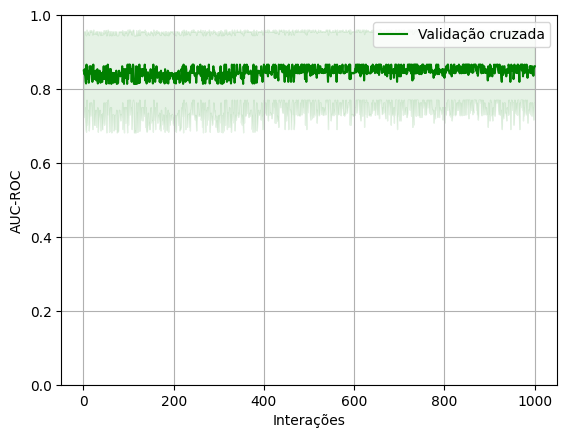

In [68]:
results_df_lof2 = pd.read_csv('./metrics_anomaly_detection/results_df_lof_dwt.csv')

results_df_lof2  = results_df_lof2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_lof2, title="LOF", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [69]:
# plot_metrics_reward(callback.rewards_history)

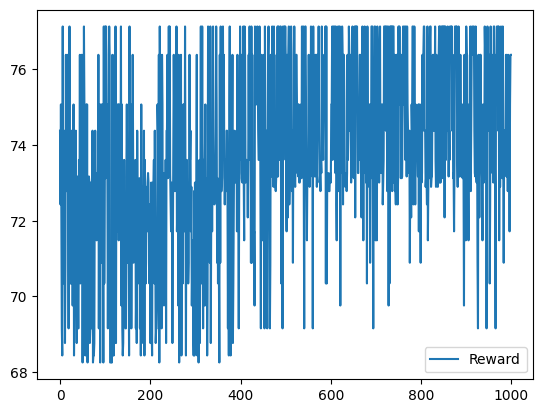

In [70]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

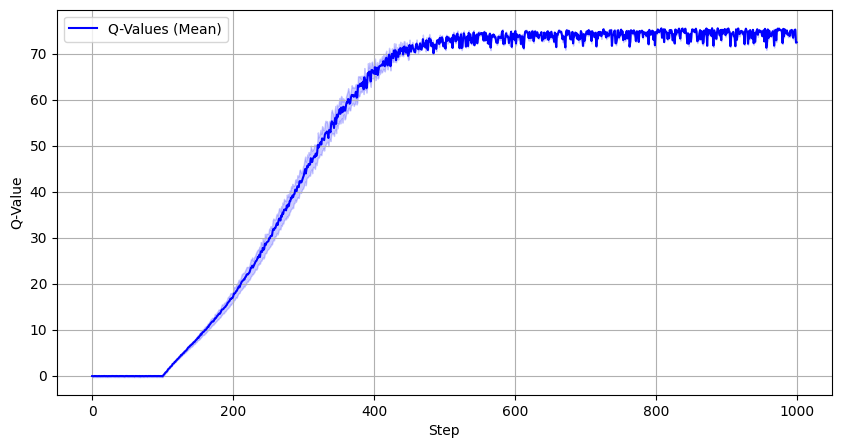

In [71]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [72]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_anomaly_detection/q_values_mean_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_anomaly_detection/q_values_q1_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_anomaly_detection/q_values_q2_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_anomaly_detection/q_values_std_history_lof_dwt.csv', index=False)

In [73]:
best_params['params']

{'n_neighbors': 3.2586333751678467, 'contamination': 0.004839002154767513}

In [74]:
n_neighbors_best = int(round(best_params['params'].get('n_neighbors'), 0))
contamination_best = round(float(best_params['params'].get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=3, contamination=0.00484


In [75]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

In [76]:
best_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [77]:
best_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_skew_L1',
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00484, n_jobs=-1,
                                    n_neighbors=3, novelty=True))])

In [78]:
scores_dev = -best_model_lof.decision_function(X_dev)


fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 0.1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

# y_pred = best_model_lof.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 0.1): -1.2643, AUC: 0.9691
Melhore threshold:  -1.2643075596613884


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.94144   0.95009   0.94574     19594
         1.0    0.89822   0.88170   0.88989      9789

    accuracy                        0.92730     29383
   macro avg    0.91983   0.91590   0.91781     29383
weighted avg    0.92704   0.92730   0.92713     29383

Specificity: 0.9500867612534449
Gini:  0.9382031342077246
ROC AUC::  0.9691015671038623


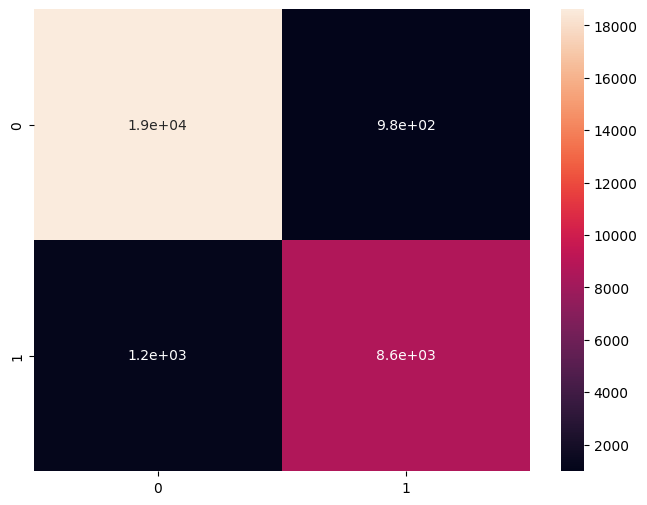

In [79]:
metrics(y_dev, y_pred, scores_dev)

In [80]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [81]:
# y_pred = best_model_lof.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

scores_valid = -best_model_lof.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

In [82]:

# scores_valid = -best_model_lof.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores_valid)
# # Calcular a curva ROC  
# fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99970   0.64503   0.78412      5099
         1.0    0.55419   0.99956   0.71304      2251

    accuracy                        0.75361      7350
   macro avg    0.77694   0.82229   0.74858      7350
weighted avg    0.86326   0.75361   0.76235      7350

Specificity: 0.6450284369484213
Gini:  0.9922393124356317
ROC AUC::  0.9961196562178158


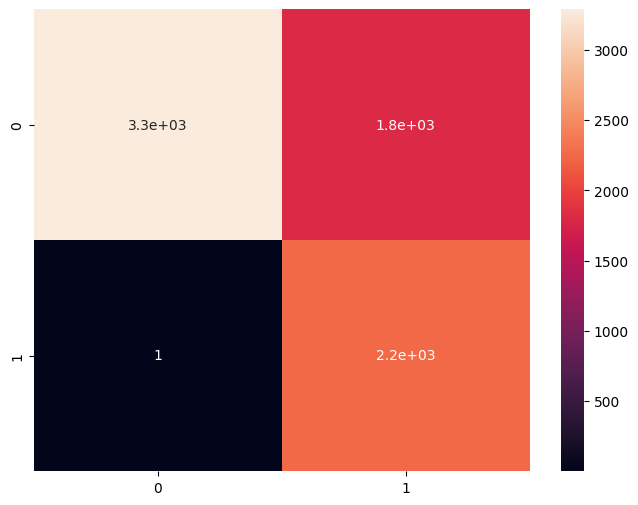

In [83]:
metrics(y_valid, y_pred, scores_valid)

In [84]:
with open('./models/pipeline_LOF_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_lof, file)

In [85]:
# with open('./models/pipeline_LOF_RL_old.pkl', 'rb') as f:
#     lof_old = pickle.load(f) 

# lof_old

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [86]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv_Pyod(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv_Pyod, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # # Histórico de métricas
        # self.metrics_history = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        # }

        self.metrics_history = {
            'roc_auc': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        # self.entropy_history = []  # Histórico de entropia
        # self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    # def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
    #     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    #     try:
    #         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    #     except:
    #           f1_scores = 0    
    #     best_idx = np.argmax(f1_scores)
    #     return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        # split_scores = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        # }
        split_scores = {
            'roc_auc': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            # y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            # precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            # recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            # f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)#, max_fpr=0.1)
            # try:
            #     roc_auc = roc_auc_score(y_test_split, y_pred)
            # except:
                # roc_auc=0    
            # pr_auc = average_precision_score(y_test_split, y_scores)      

            # # Calcular especificidade
            # tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            # specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # split_scores['f1_score'].append(f1)
            # split_scores['precision'].append(precision)
            # split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            # split_scores['pr_auc'].append(pr_auc)
            # split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            # "mean_test_f1_score": np.mean(split_scores['f1_score']),
            # "std_test_f1_score": np.std(split_scores['f1_score']),
            # "mean_test_specificity": np.mean(split_scores['specificity']),
            # "std_test_specificity": np.std(split_scores['specificity']),
            # "mean_test_precision": np.mean(split_scores['precision']),
            # "std_test_precision": np.std(split_scores['precision']),
            # "mean_test_recall": np.mean(split_scores['recall']),
            # "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            # "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            # "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        # reward = 1*(np.mean(split_scores['roc_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)

#### PCA

In [87]:
def pca_factory(**params):
    return PCA(
        contamination=params['contamination'],
        n_components=params['n_components']
    )

n_comp = train.shape[1]-1

param_ranges_pca = {
    'contamination': (0.0001, 0.005),
    'n_components': (0.5, 1)
}

In [88]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, pca_factory, param_ranges_pca)

# Modelo SAC
model_pca_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)
start_time = time.time()  # Inicia o cronômetro
# Treinamento do agente
callback = SACMetricsCallback()
model_pca_sac.learn(total_timesteps=1000, callback=callback)

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 81.5     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 23       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 81.3     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 44       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 81.2     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [89]:
results_df_pca = env.get_results_table()
results_df_pca.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.0010793457040563226, 'n_co...","{'roc_auc': [0.8030001563179678, 0.88472642348...",0.895017,0.079666,2.424065,0.387507,0.036814,0.001602
1,"{'contamination': 0.0012916302075609565, 'n_co...","{'roc_auc': [0.8005330292873949, 0.88467081850...",0.894178,0.080623,1.718767,0.214353,0.039453,0.006307
2,"{'contamination': 0.003081483533605933, 'n_com...","{'roc_auc': [0.8019187905683831, 0.88475266903...",0.894664,0.080079,1.643528,0.233430,0.031506,0.003505
3,"{'contamination': 0.002094617113471031, 'n_com...","{'roc_auc': [0.8030001563179678, 0.88472642348...",0.895017,0.079666,1.701156,0.282692,0.031582,0.001881
4,"{'contamination': 0.0006000421126373112, 'n_co...","{'roc_auc': [0.7946076793573882, 0.88439946619...",0.892113,0.082941,1.744414,0.260922,0.053949,0.004311


In [90]:
results_df_pca.to_csv('./metrics_anomaly_detection/results_df_pca_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

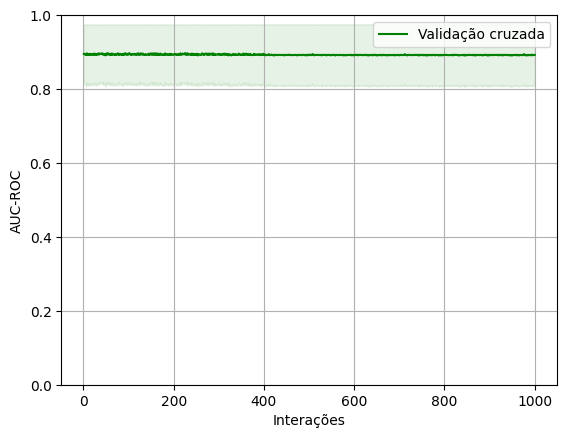

In [91]:
results_df_pca2 = pd.read_csv('./metrics_anomaly_detection/results_df_pca_dwt.csv')

results_df_pca2  = results_df_pca2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [92]:
results_df_pca['roc_auc_adjusted'] = results_df_pca['mean_test_roc_auc'] - results_df_pca['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_pca.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.004082611296325922, 'n_components': 0.5029473304748535}

Métricas: params               {'contamination': 0.004082611296325922, 'n_com...
fold_scores          {'roc_auc': [0.8079659985946364, 0.88488256227...
mean_test_roc_auc                                             0.896717
std_test_roc_auc                                              0.077748
mean_fit_time                                                 1.653505
std_fit_time                                                   0.17316
mean_score_time                                               0.029092
std_score_time                                                0.003474
roc_auc_adjusted                                              0.818969
Name: 7, dtype: object


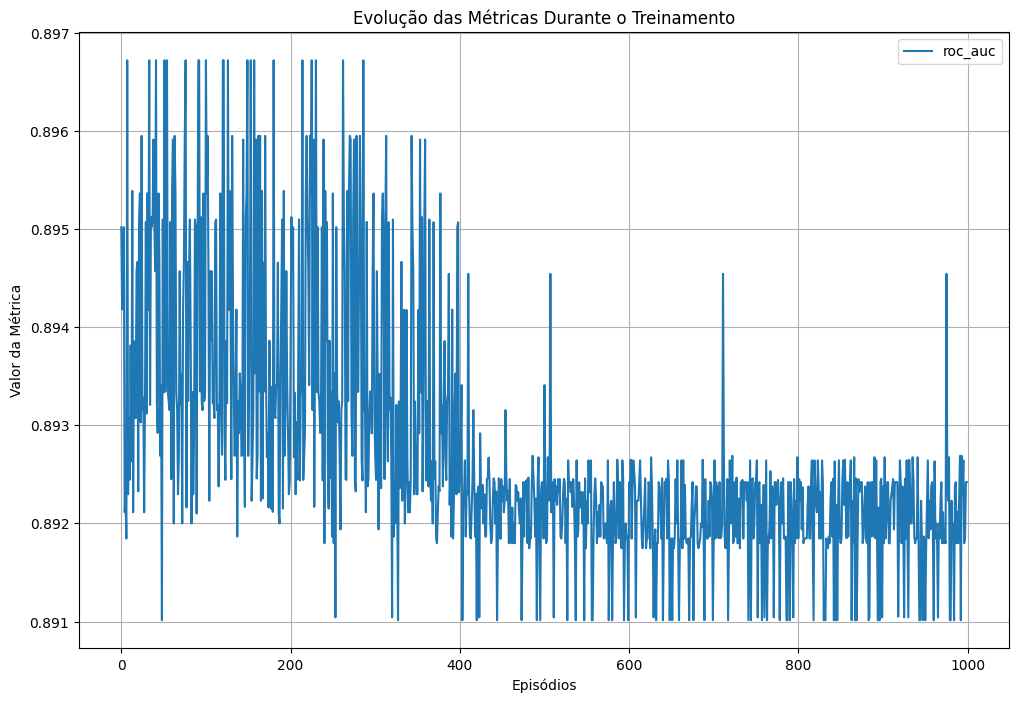

In [93]:
plot_metrics(env.metrics_history)

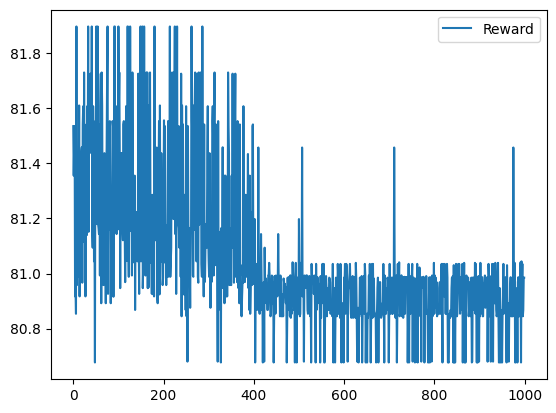

In [94]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

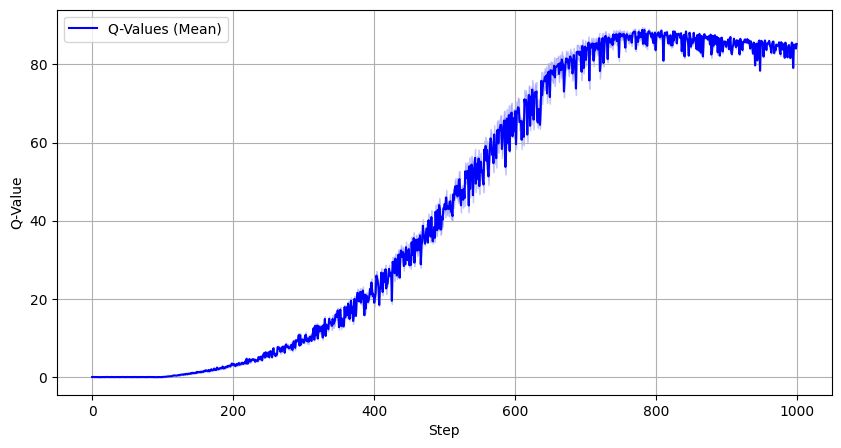

In [95]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_anomaly_detection/q_values_mean_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_anomaly_detection/q_values_q1_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_anomaly_detection/q_values_q2_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_anomaly_detection/q_values_std_history_pca_dwt.csv', index=False)
# pd.DataFrame(callback.entropy_history).to_csv('./metrics_anomaly_detection/entropy_history_pca_dwt.csv', index=False)

In [97]:
best_params['params']

{'contamination': 0.004082611296325922, 'n_components': 0.5029473304748535}

In [98]:

contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_components_best = round(float(best_params['params'].get('n_components')), 2)


print(f"Melhores hiperparâmetros encontrados: contamination={contamination_best}, "
      f"n_components={n_components_best}")

Melhores hiperparâmetros encontrados: contamination=0.00408, n_components=0.5


In [99]:
if n_components_best==1.0:
    n_components_best=0.99
else:
    pass

In [100]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                n_components = n_components_best
                
                )

best_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 PCA(contamination=0.00408, copy=True, iterated_power='auto', n_components=0.5,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False))])

In [101]:
scale_pca = best_model_pca[0]

In [102]:
media = scale_pca.mean_

desvio_padrao = scale_pca.scale_

print("Média calculada pelo StandardScaler:", media)
print("Desvio padrão calculado pelo StandardScaler:", desvio_padrao)

Média calculada pelo StandardScaler: [ 1.00099177e+07 -5.78383376e-01  4.43979111e+06  1.07945866e+05
  6.70432641e-02 -6.64008356e-01  9.34978975e-02  9.85394944e+02
  3.20734484e+00 -6.68357628e-02  2.12787625e+01  7.33501142e+01
  2.09768320e-01  7.38682354e-03  1.99527093e-02  1.54036925e-06
  1.13389718e-03  2.92938164e+00  7.12453477e-04  3.56719282e+01
  2.17542930e+06  7.81025315e+02 -4.52825595e-04 -9.86211941e-01
  2.60085566e-03  1.25070742e+00  4.54118661e+00 -5.05044159e-01
  3.60349227e+00  8.51325184e+00 -6.06566021e-08  9.07905537e+04
  1.41561718e+07  2.36756011e-01 -3.27222047e-03 -5.23038119e-04
  9.99085876e+02  1.16538400e+00 -2.50541436e+00  3.00561911e+01
  1.31692099e+07  4.85205277e+03  5.02250137e+00  1.00000001e+00
  1.29310185e+01  2.82796211e-01 -1.65251004e-01 -4.50836267e-02
  8.16976835e+00  1.34025929e-02  3.85404515e+00 -2.45752874e-01
  6.58911840e+01  3.09219788e-04  1.17297828e+02  1.18284457e-02]
Desvio padrão calculado pelo StandardScaler: [1.8688

In [103]:
# y_pred = best_model_pca.predict(development[feature_model])

scores_dev = best_model_pca.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold: 2684.0396, AUC: 0.9360
Melhore threshold:  2684.03958967829


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93112   0.94861   0.93978     19594
         1.0    0.89311   0.85954   0.87600      9789

    accuracy                        0.91893     29383
   macro avg    0.91212   0.90407   0.90789     29383
weighted avg    0.91846   0.91893   0.91853     29383

Specificity: 0.9486067163417373
Gini:  0.8719435743884647
ROC AUC::  0.9359717871942324


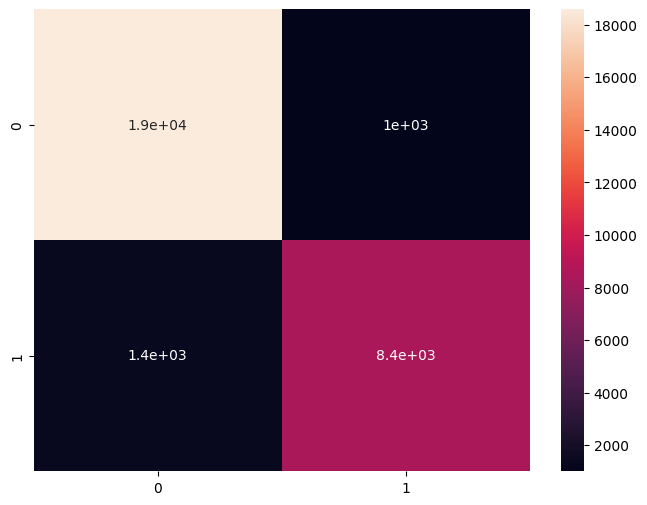

In [104]:
metrics(y_dev, y_pred, scores_dev)

In [105]:
# y_pred = best_model_pca.predict(validation[feature_model])
# y_test = validation.target.values

scores_valid = best_model_pca.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.94764   0.97311      5099
         1.0    0.89396   1.00000   0.94401      2251

    accuracy                        0.96367      7350
   macro avg    0.94698   0.97382   0.95856      7350
weighted avg    0.96753   0.96367   0.96420      7350

Specificity: 0.9476367915277505
Gini:  0.9915491134270888
ROC AUC::  0.9957745567135444


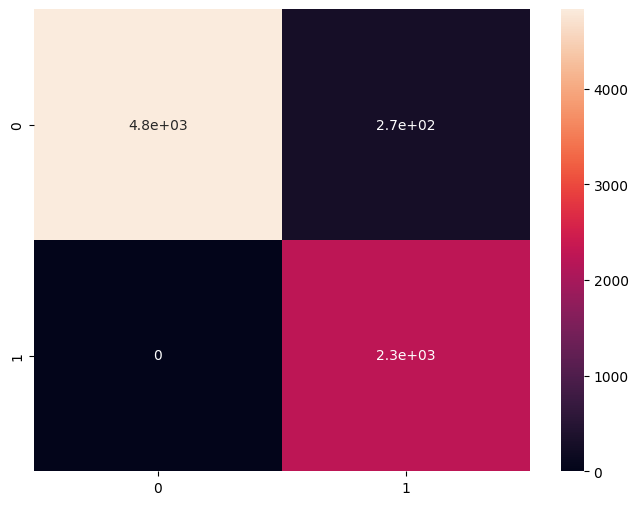

In [106]:
metrics(y_valid, y_pred, scores_valid)

In [107]:
with open('./models/pipeline_PCA_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_pca, file)

In [108]:
# with open('./models/pipeline_PCA_RL_old.pkl', 'rb') as f:
#     pca_old = pickle.load(f) 
# pca_old

#### LODA

In [278]:
def loda_factory(**params):
    return LODA(
        contamination=params['contamination'],
        n_bins=int(params['n_bins']),
        n_random_cuts=int(params['n_random_cuts'])
    )

param_ranges_loda = {
    'contamination': (0.0001, 0.005),
    'n_bins': (50, 5000),
    'n_random_cuts': (10, 1000)
}

In [279]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, loda_factory, param_ranges_loda)

# Modelo SAC
model_loda_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_loda_sac.learn(total_timesteps=1000, callback=callback)


total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 78.1     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 29       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 76.7     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 42       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 77.4     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [280]:
results_df_loda = env.get_results_table()
results_df_loda.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.0008657589205540717, 'n_bi...","{'roc_auc': [0.6926335532272669, 0.88603336298...",0.858176,0.125349,1.888530,0.568984,1.460382,0.320485
1,"{'contamination': 0.0003577337192837149, 'n_bi...","{'roc_auc': [0.8096444190739882, 0.89021040925...",0.898371,0.075996,1.413365,0.522035,0.873332,0.085217
2,"{'contamination': 0.0034006163477897644, 'n_bi...","{'roc_auc': [0.7976858448336912, 0.88211254448...",0.892304,0.081735,0.913265,0.208691,0.710242,0.055532
3,"{'contamination': 0.00048202130710706115, 'n_b...","{'roc_auc': [0.7204824981309266, 0.90373042704...",0.873533,0.114643,1.261786,0.442615,1.135378,0.050650
4,"{'contamination': 0.0017014165641739964, 'n_bi...","{'roc_auc': [0.6180251846724489, 0.81595284697...",0.809866,0.154213,0.119723,0.054138,0.108728,0.003130


In [281]:
results_df_loda.to_csv('./metrics_anomaly_detection/results_df_loda_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

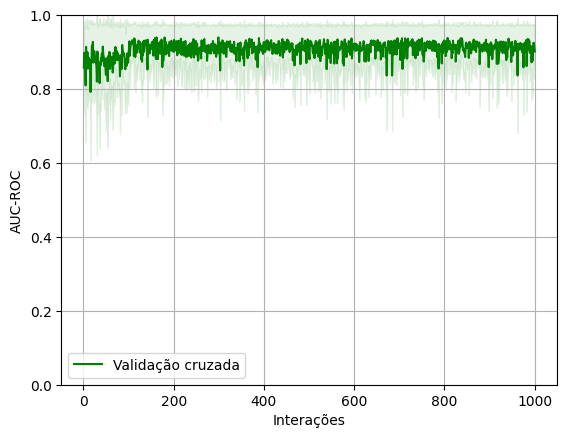

In [282]:
results_df_loda2 = pd.read_csv('./metrics_anomaly_detection/results_df_loda_dwt.csv')

results_df_loda2  = results_df_loda2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [283]:

results_df_loda['roc_auc_adjusted'] = results_df_loda['mean_test_roc_auc'] - results_df_loda['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_loda.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.004999999888241291, 'n_bins': 50.0, 'n_random_cuts': 1000.0}

Métricas: params               {'contamination': 0.004999999888241291, 'n_bin...
fold_scores          {'roc_auc': [0.9245110319033486, 0.89823131672...
mean_test_roc_auc                                             0.939485
std_test_roc_auc                                              0.041182
mean_fit_time                                                 1.013115
std_fit_time                                                  0.338164
mean_score_time                                                0.81793
std_score_time                                                0.006632
roc_auc_adjusted                                              0.898304
Name: 179, dtype: object


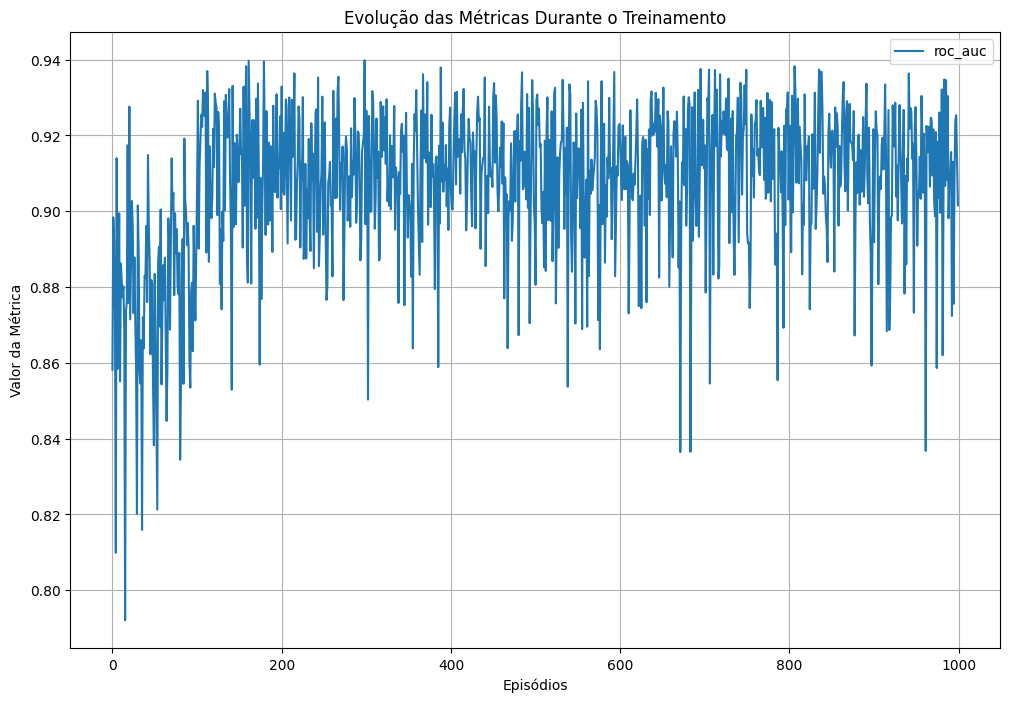

In [284]:
plot_metrics(env.metrics_history)

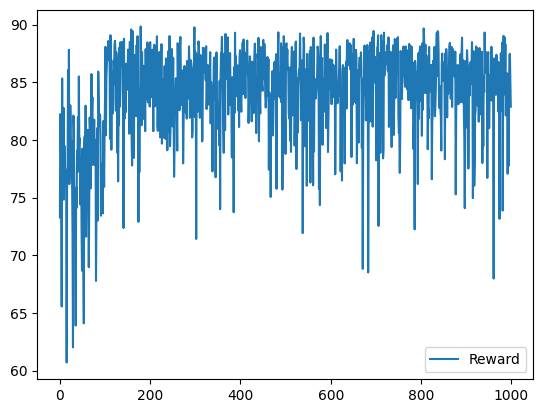

In [285]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()


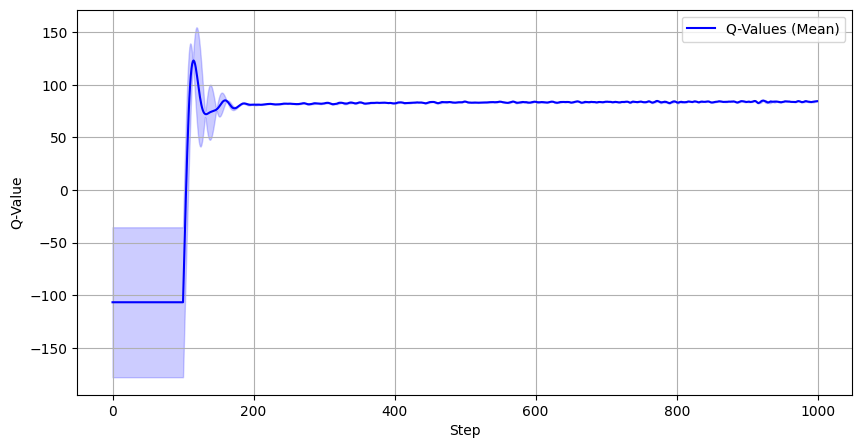

In [286]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [287]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_anomaly_detection/q_values_mean_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_anomaly_detection/q_values_std_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_anomaly_detection/q_values_q1_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_anomaly_detection/q_values_q2_history_loda_dwt.csv', index=False)

In [288]:
best_params['params']

{'contamination': 0.004999999888241291,
 'n_bins': 50.0,
 'n_random_cuts': 1000.0}

In [289]:
n_random_cuts_best = int(best_params['params'].get('n_random_cuts'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_bins_best = int(best_params['params'].get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")

Melhores hiperparâmetros encontrados: n_random_cuts=1000, contamination=0.005, n_bins=50


In [290]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

best_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'T-JUS-CKP_entropy_L1',
                                                 'T-JUS-CKP_skew_L1',
                                                 'T-JUS-CKP_kurtosis_L1',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 LODA(contamination=0.005, n_bins=50, n_random_cuts=1000))])

In [291]:
# y_pred = best_model_loda.predict(validation[feature_model])
# y_test = validation.target.values

scores_dev = best_model_loda.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold: 0.0029, AUC: 0.9372
Melhore threshold:  0.0028994106317958256


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93153   0.91033   0.92081     19594
         1.0    0.82833   0.86607   0.84678      9789

    accuracy                        0.89559     29383
   macro avg    0.87993   0.88820   0.88380     29383
weighted avg    0.89715   0.89559   0.89615     29383

Specificity: 0.9103296927630907
Gini:  0.8743617615550523
ROC AUC::  0.9371808807775261


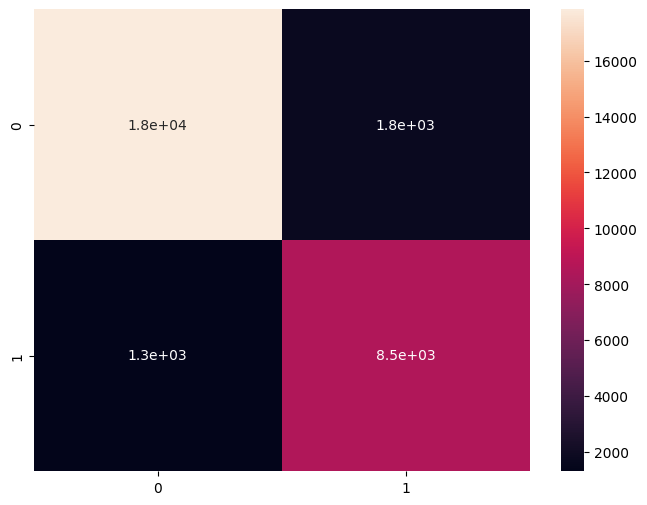

In [292]:
metrics(y_dev, y_pred, scores_dev)

In [293]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [294]:
scores_valid = best_model_loda.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = best_model_loda.predict(X_valid)

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.89233   0.94310      5099
         1.0    0.80393   1.00000   0.89131      2251

    accuracy                        0.92531      7350
   macro avg    0.90196   0.94617   0.91721      7350
weighted avg    0.93995   0.92531   0.92724      7350

Specificity: 0.8923318297705433
Gini:  0.9787481086395196
ROC AUC::  0.9893740543197598


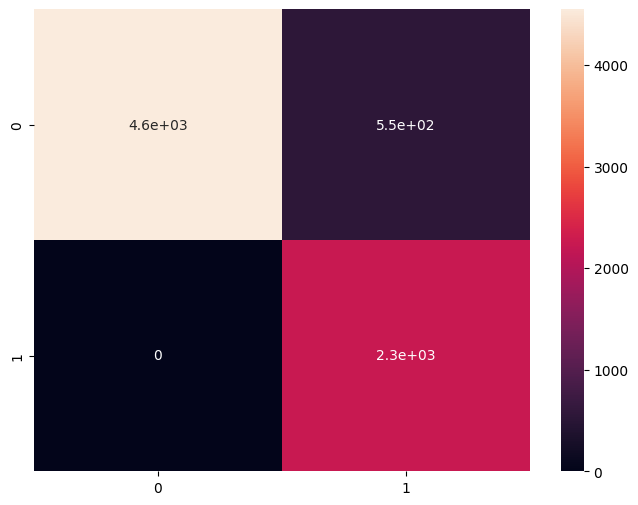

In [295]:
metrics(y_valid, y_pred, scores_valid)

In [296]:
with open('./models/pipeline_LODA_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_loda, file)

### OCSVM

In [195]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv_Pyod_Cat_Num(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior/superior ou lista de categorias
        """
        super(AnomalyDetectionEnv_Pyod_Cat_Num, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Identificar parâmetros categóricos e contínuos
        self.param_names = list(param_ranges.keys())
        self.categorical_params = {k: v for k, v in param_ranges.items() if isinstance(v, list)}
        self.continuous_params = {k: v for k, v in param_ranges.items() if not isinstance(v, list)}

        # Espaço de ação: para categorias usamos índices normalizados
        low_bounds = []
        high_bounds = []
        for k in self.param_names:
            if k in self.categorical_params:
                low_bounds.append(0)
                high_bounds.append(len(self.categorical_params[k]) - 1)
            else:
                low_bounds.append(self.param_ranges[k][0])
                high_bounds.append(self.param_ranges[k][1])

        self.action_space = spaces.Box(low=np.array(low_bounds, dtype=np.float32),
                                       high=np.array(high_bounds, dtype=np.float32),
                                       dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array(low_bounds, dtype=np.float32),
                                            high=np.array(high_bounds, dtype=np.float32),
                                            dtype=np.float32)

        # Estado inicial (meio do intervalo ou primeira categoria)
        self.state = np.array([
            0 if k in self.categorical_params else (self.param_ranges[k][0] + self.param_ranges[k][1]) / 2
            for k in self.param_names
        ], dtype=np.float32)

        self.metrics_history = {'roc_auc': []}
        self.rewards_history = []
        self.results = []

    def step(self, action):
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        params = {}
        for i, k in enumerate(self.param_names):
            if k in self.categorical_params:
                # Converter para inteiro e mapear para categoria
                idx = int(np.clip(round(action[i]), 0, len(self.categorical_params[k]) - 1))
                params[k] = self.categorical_params[k][idx]
            else:
                params[k] = float(np.clip(action[i], *self.param_ranges[k]))

        model = self.model_factory(**params)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        split_scores = {'roc_auc': [], 'fit_time': [], 'score_time': []}

        for train_index, test_index in self.tscv.split(self.X):
            X_train_split = self.X[train_index][self.y[train_index] == 0]
            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            score_time = time.time() - start_score

            roc_auc = roc_auc_score(y_test_split, y_scores)

            split_scores['roc_auc'].append(roc_auc)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        reward = 100 * (np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
        self.rewards_history.append(reward)
        self.metrics_history['roc_auc'].append(np.mean(split_scores['roc_auc']))
        self.state = np.array(list(action), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([
            0 if k in self.categorical_params else (self.param_ranges[k][0] + self.param_ranges[k][1]) / 2
            for k in self.param_names
        ], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        return pd.DataFrame(self.results)


In [196]:
from pyod.models.ocsvm import OCSVM

def ocsvm_factory(**params):
    return OCSVM(
        kernel=params['kernel'],
        nu=params['nu'],
        gamma=params['gamma']
    )

param_ranges_ocsvm = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # kernels suportados
    'nu': (0.0001, 0.005),  # proporção de outliers esperada (0 < nu ≤ 1)
    'gamma': (0.001, 0.1)  # parâmetro do kernel RBF/poly/sigmoid
}

In [197]:
# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod_Cat_Num(X_dev, y_dev, tscv, feature_model, ocsvm_factory, param_ranges_ocsvm)

# Modelo SAC
model_ocsvm_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_ocsvm_sac.learn(total_timesteps=1000, callback=callback)


total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 17.4     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 11       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 24.2     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 20       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 24.7     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [198]:
results_df_ocsvm = env.get_results_table()
results_df_ocsvm.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'kernel': 'sigmoid', 'nu': 0.0046494258567690...","{'roc_auc': [0.22623067937386915, 0.4194577402...",0.244931,0.135513,0.340163,0.256219,0.056346,0.027079
1,"{'kernel': 'linear', 'nu': 0.00110825372394174...","{'roc_auc': [0.00048630869352638256, 0.1689848...",0.215636,0.197488,1.582961,0.741628,0.256175,0.055917
2,"{'kernel': 'linear', 'nu': 0.00028483907226473...","{'roc_auc': [0.00015756651379472453, 0.1678758...",0.357600,0.392917,0.633277,0.116323,0.107568,0.029689
3,"{'kernel': 'poly', 'nu': 0.0019869802054017782...","{'roc_auc': [0.6926211926211927, 0.67546174377...",0.650811,0.047514,0.712246,0.371449,0.147359,0.027394
4,"{'kernel': 'linear', 'nu': 0.00161960162222385...","{'roc_auc': [0.004635102423228142, 0.169579181...",0.298094,0.305885,0.645512,0.224904,0.130655,0.044892


In [199]:
results_df_ocsvm.to_csv('./metrics_anomaly_detection/results_df_ocsvm_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

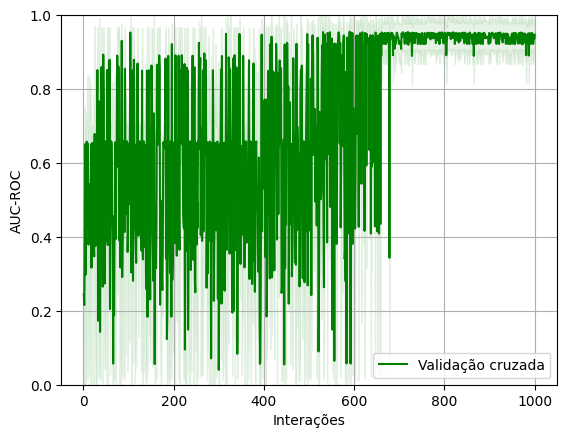

In [200]:
results_df_ocsvm2 = pd.read_csv('./metrics_anomaly_detection/results_df_ocsvm_dwt.csv')

results_df_ocsvm2  = results_df_ocsvm2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_ocsvm2, title="ocsvm", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [201]:
results_df_ocsvm['roc_auc_adjusted'] = results_df_ocsvm['mean_test_roc_auc'] - results_df_ocsvm['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_ocsvm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_ocsvm.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 



Melhores parâmetros encontrados (máxima média ajustada): {'kernel': 'rbf', 'nu': 0.00013298630074132234, 'gamma': 0.0011264937929809093}

Métricas: params               {'kernel': 'rbf', 'nu': 0.00013298630074132234...
fold_scores          {'roc_auc': [0.9686211656525976, 0.89827179715...
mean_test_roc_auc                                               0.9551
std_test_roc_auc                                              0.041983
mean_fit_time                                                 0.152027
std_fit_time                                                  0.087857
mean_score_time                                               0.064967
std_score_time                                                0.005315
roc_auc_adjusted                                              0.913117
Name: 589, dtype: object


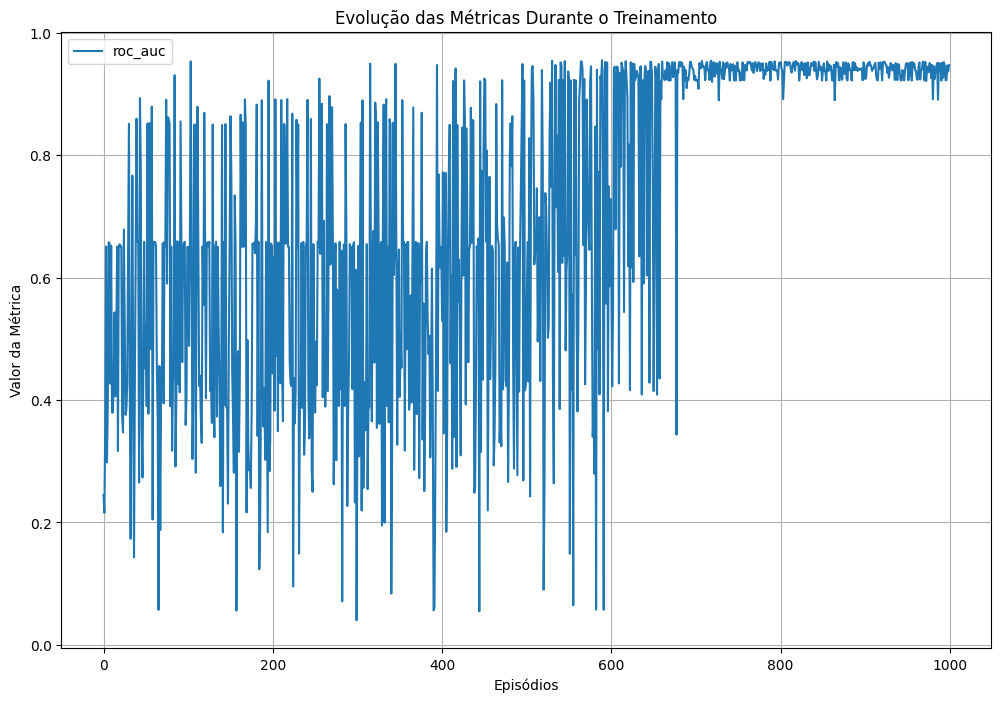

In [202]:
plot_metrics(env.metrics_history)

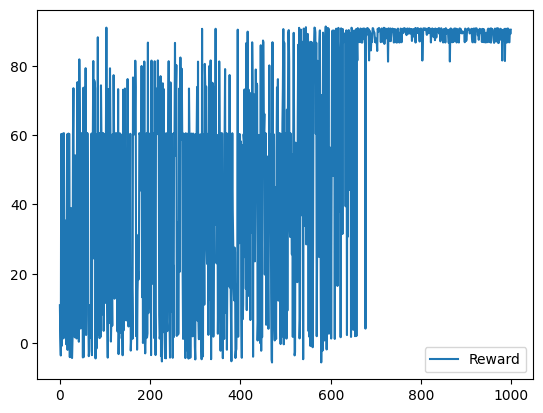

In [203]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

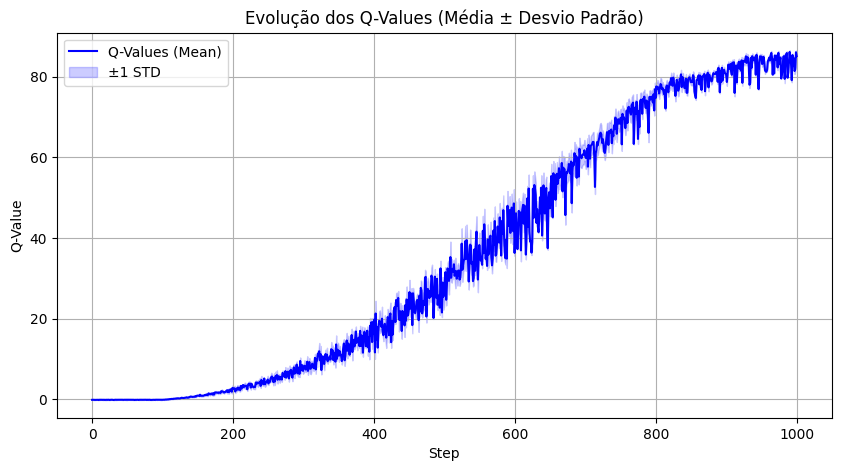

In [204]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()

# Plot dos Q-values: média e desvio padrão
q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue", label="±1 STD")
plt.xlabel("Step")
plt.ylabel("Q-Value")
plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()


In [205]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_anomaly_detection/q_values_mean_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_anomaly_detection/q_values_std_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_anomaly_detection/q_values_q1_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_anomaly_detection/q_values_q2_history_ocsvm_dwt.csv', index=False)


In [206]:
# Extrair melhores hiperparâmetros
kernel_best = best_params['params'].get('kernel')
nu_best = round(float(best_params['params'].get('nu')), 5)
gamma_best = round(float(best_params['params'].get('gamma')), 3)

print(f"Melhores hiperparâmetros encontrados: kernel={kernel_best}, nu={nu_best}, gamma={gamma_best}")


Melhores hiperparâmetros encontrados: kernel=rbf, nu=0.00013, gamma=0.001


In [207]:
estimator = OCSVM(kernel=kernel_best, nu=nu_best, gamma=gamma_best)

best_model_ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
    ('estimator', estimator)
])

best_model_ocsvm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean',
                                                 'P-JUS-CKGL_skew_L1',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_skew_L0',
                                                 'P-MON-CKP_kurtosis_L0',
                                                 'P-MON-CKP_mean_L1',
                                                 'P-MON-CKP_std_L1',
                                                 'P-MON-CKP_entropy_L1',
                                                 'P-MON-CKP_skew_L1',
                                                 'P-MON-CKP_kurtosis_L1',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-TPT_s...
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_skew_L0',
                                                 'P-JUS-CKGL_kurtosis_L0',
                                                 'P-JUS-CKGL_mean_L1',
                                                 'P-JUS-CKGL_std_L1',
                                                 'P-JUS-CKGL_entropy_L1',
                                                 'T-JUS-CKP_kurtosis_L0',
                                                 'T-TPT_entropy_L1',
                                                 'T-TPT_kurtosis_L1', ...])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.001,
   kernel='rbf', max_iter=-1, nu=0.00013, shrinking=True, tol=0.001,
   verbose=False))])

In [208]:
scores_dev = best_model_ocsvm.decision_function(X_dev)

In [209]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")


Melhor Threshold: -0.0552, AUC: 0.9462


In [210]:
y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhor threshold: ", best_threshold)

Melhor threshold:  -0.0551690750260095


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.93126   0.96514   0.94790     19594
         1.0    0.92475   0.85739   0.88980      9789

    accuracy                        0.92924     29383
   macro avg    0.92800   0.91127   0.91885     29383
weighted avg    0.92909   0.92924   0.92854     29383

Specificity: 0.9651423905277126
Gini:  0.8923611464115977
ROC AUC::  0.9461805732057988


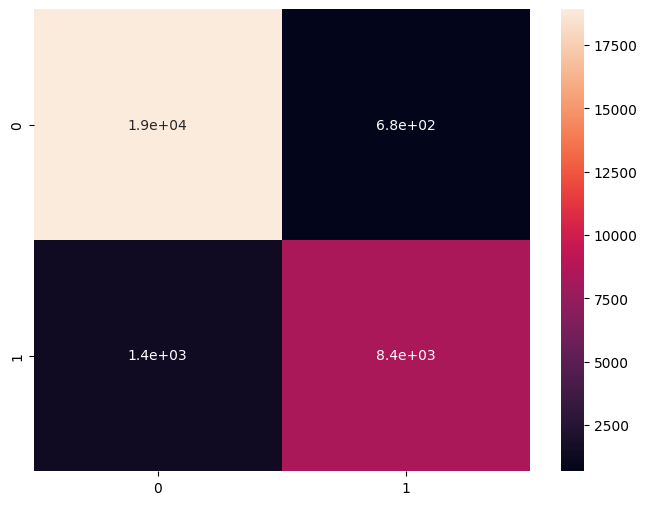

In [211]:
metrics(y_dev, y_pred, scores_dev)

In [212]:
scores_valid = best_model_ocsvm.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.95744   0.97826      5099
         1.0    0.91207   1.00000   0.95402      2251

    accuracy                        0.97048      7350
   macro avg    0.95604   0.97872   0.96614      7350
weighted avg    0.97307   0.97048   0.97083      7350

Specificity: 0.9574426358109434
Gini:  0.9865499188915974
ROC AUC::  0.9932749594457987


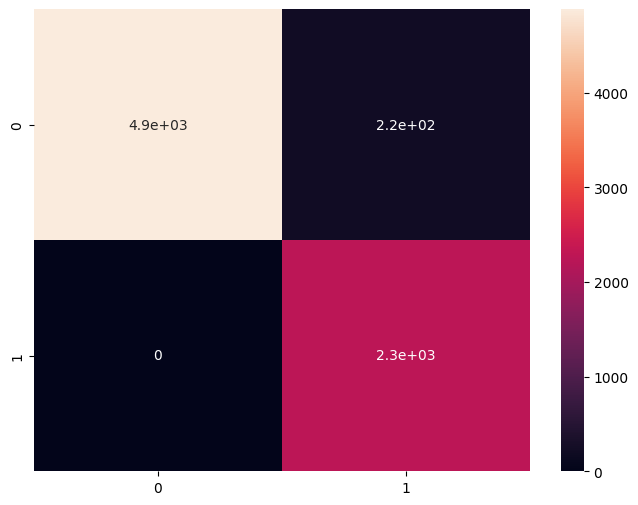

In [213]:
metrics(y_valid, y_pred, scores_valid)

In [214]:
with open('./models/pipeline_OCSVM_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_ocsvm, file)